# Spotify Album Artwork Fetcher

This notebook demonstrates how to fetch album artwork from Spotify using their Web API. We'll create a table containing images for tracks, albums, and artists from our dataset.

## Requirements for Spotify OAuth

To use the Spotify Web API, you need to:

1. **Create a Spotify App** at https://developer.spotify.com/dashboard
2. **Set up OAuth 2.0 credentials** (Client ID and Client Secret)
3. **Define redirect URIs** in your app settings
4. **Request appropriate scopes** (for public data, minimal scopes are needed)

## OAuth Approval Process

For this use case (fetching public album/track/artist data), **no special approval is needed**. The standard OAuth flow works for:
- Public track information
- Album artwork
- Artist information
- Basic metadata

**Extended quota requests** are only needed for:
- High-volume applications (>10,000 requests per day)
- Commercial applications
- Applications requiring special rate limits

In [23]:
# Required imports - FIXED VERSION
import pandas as pd
import requests
import base64
import json
import time
from IPython.display import HTML, display, Image as IPythonImage
from urllib.parse import urlencode
import os
from typing import Dict, List, Optional

# For displaying images in the notebook - FIXED IMPORTS
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from PIL import Image  # This is the correct PIL Image for opening images
from io import BytesIO

print("All required packages imported successfully!")

All required packages imported successfully!


## 🔐 Secure Credential Setup

**IMPORTANT:** Never commit your Spotify API credentials to version control!

### Quick Setup (Recommended):

1. **Copy the example file:**
   ```bash
   cp .env.example .env
   ```

2. **Edit the `.env` file** with your actual credentials:
   ```
   SPOTIFY_CLIENT_ID=your_actual_client_id_from_spotify
   SPOTIFY_CLIENT_SECRET=your_actual_client_secret_from_spotify
   ```

3. **The `.env` file is already in `.gitignore`** - it won't be committed to git

### Alternative: Environment Variables

Set these in your terminal before starting Jupyter:
```bash
export SPOTIFY_CLIENT_ID=your_actual_client_id
export SPOTIFY_CLIENT_SECRET=your_actual_client_secret
jupyter notebook
```

### ✅ Security Best Practices:
- ✅ Credentials stored in `.env` file (not tracked by git)
- ✅ `.env` file listed in `.gitignore`
- ✅ No hardcoded secrets in notebook
- ✅ Environment variables used for credential access

In [24]:
# Spotify API Configuration - SECURE VERSION
# Store credentials in environment variables or .env file (NOT in the notebook!)

import os
from dotenv import load_dotenv

# Load environment variables from .env file (if it exists)
load_dotenv()

# Get credentials from environment variables
CLIENT_ID = os.getenv('SPOTIFY_CLIENT_ID')
CLIENT_SECRET = os.getenv('SPOTIFY_CLIENT_SECRET')

# Check if credentials are loaded
if not CLIENT_ID or not CLIENT_SECRET:
    print("⚠️  CREDENTIALS NOT FOUND!")
    print("Please set up your Spotify credentials using one of these methods:")
    print()
    print("METHOD 1: Create a .env file in the project root with:")
    print("SPOTIFY_CLIENT_ID=your_actual_client_id")
    print("SPOTIFY_CLIENT_SECRET=your_actual_client_secret")
    print()
    print("METHOD 2: Set environment variables in your terminal:")
    print("export SPOTIFY_CLIENT_ID=your_actual_client_id")
    print("export SPOTIFY_CLIENT_SECRET=your_actual_client_secret")
    print()
    print("Then restart this notebook.")
else:
    print("✅ Spotify credentials loaded successfully!")

# Spotify API endpoints
SPOTIFY_TOKEN_URL = "https://accounts.spotify.com/api/token"
SPOTIFY_API_BASE_URL = "https://api.spotify.com/v1"

class SpotifyAPI:
    def __init__(self, client_id: str, client_secret: str):
        self.client_id = client_id
        self.client_secret = client_secret
        self.access_token = None
        self.token_expires_at = 0
    
    def get_access_token(self) -> str:
        """Get access token using Client Credentials flow (for public data)"""
        if self.access_token and time.time() < self.token_expires_at:
            return self.access_token
        
        # Encode credentials
        credentials = f"{self.client_id}:{self.client_secret}"
        credentials_b64 = base64.b64encode(credentials.encode()).decode()
        
        # Request token
        headers = {
            "Authorization": f"Basic {credentials_b64}",
            "Content-Type": "application/x-www-form-urlencoded"
        }
        
        data = {"grant_type": "client_credentials"}
        
        response = requests.post(SPOTIFY_TOKEN_URL, headers=headers, data=data)
        
        if response.status_code == 200:
            token_data = response.json()
            self.access_token = token_data["access_token"]
            expires_in = token_data.get("expires_in", 3600)
            self.token_expires_at = time.time() + expires_in - 60  # Refresh 60s early
            return self.access_token
        else:
            raise Exception(f"Failed to get access token: {response.status_code} - {response.text}")
    
    def make_request(self, endpoint: str, params: Dict = None) -> Dict:
        """Make authenticated request to Spotify API"""
        token = self.get_access_token()
        headers = {"Authorization": f"Bearer {token}"}
        
        url = f"{SPOTIFY_API_BASE_URL}/{endpoint}"
        response = requests.get(url, headers=headers, params=params)
        
        if response.status_code == 200:
            return response.json()
        elif response.status_code == 429:  # Rate limited
            retry_after = int(response.headers.get("Retry-After", 1))
            print(f"Rate limited. Waiting {retry_after} seconds...")
            time.sleep(retry_after)
            return self.make_request(endpoint, params)
        else:
            print(f"Request failed: {response.status_code} - {response.text}")
            return None

# Initialize API client (only if credentials are available)
if CLIENT_ID and CLIENT_SECRET:
    spotify_api = SpotifyAPI(CLIENT_ID, CLIENT_SECRET)
    print("🎵 Spotify API client initialized!")
else:
    spotify_api = None
    print("❌ Spotify API client not initialized - missing credentials")

✅ Spotify credentials loaded successfully!
🎵 Spotify API client initialized!


In [25]:
# Load the Spotify tracks dataset
df = pd.read_csv("../data/processed/spotify_tracks.csv")

print(f"Dataset shape: {df.shape}")
print(f"Columns: {list(df.columns)}")
print("\nFirst few rows:")
df.head()

Dataset shape: (113999, 20)
Columns: ['track_id', 'artists', 'album_name', 'track_name', 'popularity', 'duration_ms', 'explicit', 'danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo', 'time_signature', 'track_genre']

First few rows:


,track_id,artists,album_name,track_name,popularity,duration_ms,explicit,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,time_signature,track_genre
0,5SuOikwiRyPMVoIQDJUgSV,Gen Hoshino,Comedy,Comedy,73,230666,False,0.676,0.4610,1,-6.746,0,0.1430,0.0322,0.000001,0.3580,0.715,87.917,4,acoustic
1,4qPNDBW1i3p13qLCt0Ki3A,Ben Woodward,Ghost (Acoustic),Ghost - Acoustic,55,149610,False,0.420,0.1660,1,-17.235,1,0.0763,0.9240,0.000006,0.1010,0.267,77.489,4,acoustic
2,1iJBSr7s7jYXzM8EGcbK5b,Ingrid Michaelson;ZAYN,To Begin Again,To Begin Again,57,210826,False,0.438,0.3590,0,-9.734,1,0.0557,0.2100,0.000000,0.1170,0.120,76.332,4,acoustic
3,6lfxq3CG4xtTiEg7opyCyx,Kina Grannis,Crazy Rich Asians (Original Motion Picture Sou...,Can't Help Falling In Love,71,201933,False,0.266,0.0596,0,-18.515,1,0.0363,0.9050,0.000071,0.1320,0.143,181.740,3,acoustic
4,5vjLSffimiIP26QG5WcN2K,Chord Overstreet,Hold On,Hold On,82,198853,False,0.618,0.4430,2,-9.681,1,0.0526,0.4690,0.000000,0.0829,0.167,119.949,4,acoustic


In [26]:
def get_track_with_artwork(track_id: str) -> Dict:
    """Fetch track data including album artwork from Spotify API"""
    try:
        track_data = spotify_api.make_request(f"tracks/{track_id}")
        if track_data:
            return {
                'track_id': track_data['id'],
                'track_name': track_data['name'],
                'artist_name': ', '.join([artist['name'] for artist in track_data['artists']]),
                'album_name': track_data['album']['name'],
                'album_id': track_data['album']['id'],
                'release_date': track_data['album']['release_date'],
                'popularity': track_data['popularity'],
                'duration_ms': track_data['duration_ms'],
                'album_images': track_data['album']['images'],  # List of image objects
                'album_image_url': track_data['album']['images'][0]['url'] if track_data['album']['images'] else None,
                'artist_ids': [artist['id'] for artist in track_data['artists']],
                'explicit': track_data['explicit'],
                'preview_url': track_data.get('preview_url')
            }
    except Exception as e:
        print(f"Error fetching track {track_id}: {e}")
        return None

def get_album_with_artwork(album_id: str) -> Dict:
    """Fetch album data including artwork from Spotify API"""
    try:
        album_data = spotify_api.make_request(f"albums/{album_id}")
        if album_data:
            return {
                'album_id': album_data['id'],
                'album_name': album_data['name'],
                'artist_name': ', '.join([artist['name'] for artist in album_data['artists']]),
                'release_date': album_data['release_date'],
                'total_tracks': album_data['total_tracks'],
                'album_type': album_data['album_type'],
                'popularity': album_data.get('popularity', 0),
                'album_images': album_data['images'],
                'album_image_url': album_data['images'][0]['url'] if album_data['images'] else None,
                'genres': album_data.get('genres', []),
                'label': album_data.get('label', ''),
                'copyrights': album_data.get('copyrights', [])
            }
    except Exception as e:
        print(f"Error fetching album {album_id}: {e}")
        return None

def get_artist_with_images(artist_id: str) -> Dict:
    """Fetch artist data including images from Spotify API"""
    try:
        artist_data = spotify_api.make_request(f"artists/{artist_id}")
        if artist_data:
            return {
                'artist_id': artist_data['id'],
                'artist_name': artist_data['name'],
                'popularity': artist_data['popularity'],
                'followers': artist_data['followers']['total'],
                'genres': artist_data['genres'],
                'artist_images': artist_data['images'],
                'artist_image_url': artist_data['images'][0]['url'] if artist_data['images'] else None
            }
    except Exception as e:
        print(f"Error fetching artist {artist_id}: {e}")
        return None

def display_image_in_notebook(image_url: str, title: str = "", size: tuple = (150, 150)):
    """Display an image from URL in the notebook"""
    if image_url:
        try:
            response = requests.get(image_url)
            img = Image.open(BytesIO(response.content))
            
            plt.figure(figsize=(size[0]/100, size[1]/100))
            plt.imshow(img)
            plt.axis('off')
            if title:
                plt.title(title, fontsize=10, wrap=True)
            plt.tight_layout()
            plt.show()
        except Exception as e:
            print(f"Error displaying image: {e}")
    else:
        print("No image URL provided")

print("Helper functions defined successfully!")

Helper functions defined successfully!


🧪 Testing with track ID: 5SuOikwiRyPMVoIQDJUgSV
✅ Track information fetched successfully!
🎵 Track: Comedy
🎤 Artist: Gen Hoshino
💿 Album: Comedy
🎨 Album artwork available: Yes

🖼️  Album artwork:
✅ Track information fetched successfully!
🎵 Track: Comedy
🎤 Artist: Gen Hoshino
💿 Album: Comedy
🎨 Album artwork available: Yes

🖼️  Album artwork:


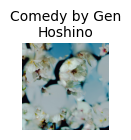

🔧 Test function ready!
Uncomment the last line and run this cell to test your Spotify API setup


In [27]:
# Test the API with a sample track from our dataset
# This will only run if credentials are properly configured

def test_spotify_api():
    """Test function to verify Spotify API connectivity"""
    if not spotify_api:
        print("❌ Cannot test API - credentials not configured")
        print("Please follow the setup instructions in the previous cell")
        return False
    
    try:
        sample_track_id = df['track_id'].iloc[0]
        print(f"🧪 Testing with track ID: {sample_track_id}")

        track_info = get_track_with_artwork(sample_track_id)
        if track_info:
            print("✅ Track information fetched successfully!")
            print(f"🎵 Track: {track_info['track_name']}")
            print(f"🎤 Artist: {track_info['artist_name']}")
            print(f"💿 Album: {track_info['album_name']}")
            print(f"🎨 Album artwork available: {'Yes' if track_info['album_image_url'] else 'No'}")
            
            # Display the album artwork
            if track_info['album_image_url']:
                print("\n🖼️  Album artwork:")
                display_image_in_notebook(
                    track_info['album_image_url'], 
                    f"{track_info['album_name']} by {track_info['artist_name']}"
                )
            return True
        else:
            print("❌ Failed to fetch track information")
            return False
            
    except Exception as e:
        print(f"❌ Error: {e}")
        return False

# Uncomment the line below to test your API setup
test_spotify_api()

print("🔧 Test function ready!")
print("Uncomment the last line and run this cell to test your Spotify API setup")

In [28]:
def create_artwork_table(track_ids: List[str], max_requests: int = 50) -> pd.DataFrame:
    """
    Create a table with track information and artwork URLs
    
    Args:
        track_ids: List of Spotify track IDs
        max_requests: Maximum number of API requests (to avoid rate limiting)
    
    Returns:
        DataFrame with track info and artwork URLs
    """
    results = []
    
    print(f"Fetching artwork for {min(len(track_ids), max_requests)} tracks...")
    
    for i, track_id in enumerate(track_ids[:max_requests]):
        if i % 10 == 0:
            print(f"Progress: {i}/{min(len(track_ids), max_requests)}")
        
        track_info = get_track_with_artwork(track_id)
        if track_info:
            results.append(track_info)
        
        # Be respectful to the API - small delay between requests
        time.sleep(0.1)
    
    if results:
        df_artwork = pd.DataFrame(results)
        print(f"\\nSuccessfully fetched artwork for {len(results)} tracks")
        return df_artwork
    else:
        print("No results obtained")
        return pd.DataFrame()

def create_html_artwork_table(df_artwork: pd.DataFrame, num_display: int = 20) -> str:
    """Create an HTML table with embedded images for display in notebook"""
    
    if df_artwork.empty:
        return "<p>No artwork data available</p>"
    
    html_parts = [
        "<style>",
        ".artwork-table { border-collapse: collapse; width: 100%; }",
        ".artwork-table th, .artwork-table td { border: 1px solid #ddd; padding: 8px; text-align: left; }",
        ".artwork-table th { background-color: #f2f2f2; }",
        ".artwork-img { width: 100px; height: 100px; object-fit: cover; }",
        "</style>",
        "<table class='artwork-table'>",
        "<tr><th>Artwork</th><th>Track</th><th>Artist</th><th>Album</th><th>Release Date</th><th>Popularity</th></tr>"
    ]
    
    for _, row in df_artwork.head(num_display).iterrows():
        img_tag = f"<img src='{row['album_image_url']}' class='artwork-img'>" if row['album_image_url'] else "No image"
        
        html_parts.append(
            f"<tr>"
            f"<td>{img_tag}</td>"
            f"<td>{row['track_name']}</td>"
            f"<td>{row['artist_name']}</td>"
            f"<td>{row['album_name']}</td>"
            f"<td>{row['release_date']}</td>"
            f"<td>{row['popularity']}</td>"
            f"</tr>"
        )
    
    html_parts.append("</table>")
    
    return "".join(html_parts)

print("Artwork table functions defined successfully!")

Artwork table functions defined successfully!


📝 Selected 570 tracks across different genres
Fetching artwork for 25 tracks...
Progress: 0/25
Progress: 10/25
Progress: 10/25
Progress: 20/25
Progress: 20/25
\nSuccessfully fetched artwork for 25 tracks

📊 Artwork DataFrame created:
                   track_name              artist_name  \
0                      Comedy              Gen Hoshino   
1            Ghost - Acoustic             Ben Woodward   
2              To Begin Again  Ingrid Michaelson, ZAYN   
3  Can't Help Falling In Love             Kina Grannis   
4                     Hold On         Chord Overstreet   

                                          album_name  popularity  
0                                             Comedy          63  
1                                   Ghost (Acoustic)          43  
2                                     To Begin Again          48  
3  Crazy Rich Asians (Original Motion Picture Sou...          67  
4                                            Hold On          79  

🖼️  Displaying

Artwork,Track,Artist,Album,Release Date,Popularity
,Comedy,Gen Hoshino,Comedy,2022-04-08,63
,Ghost - Acoustic,Ben Woodward,Ghost (Acoustic),2021-04-30,43
,To Begin Again,"Ingrid Michaelson, ZAYN",To Begin Again,2021-03-17,48
,Can't Help Falling In Love,Kina Grannis,Crazy Rich Asians (Original Motion Picture Soundtrack),2018-08-10,67
,Hold On,Chord Overstreet,Hold On,2017-02-03,79
,Jireh (My Provider),"Limoblaze, Lecrae, Happi",Jireh (My Provider),2022-07-01,60
,Ainda Há Tempo,Criolo,Ainda Há Tempo,2016-05-24,0
,Fellini,Criolo,Fellini,2021-01-08,0
,Lion Man,Criolo,Nó na Orelha,2011-01-01,0
,Espiral de Ilusão,Criolo,Espiral de Ilusão,2017-04-28,0



💾 Results saved to ../data/processed/spotify_tracks_with_artwork.csv

📈 Running artwork analysis:
🎨 ARTWORK AVAILABILITY ANALYSIS
Total tracks analyzed: 25
Tracks with artwork: 25
Artwork availability rate: 100.0%
\n📏 IMAGE DIMENSIONS
------------------------------
Most common image sizes:
640x640    25
300x300    25
64x64      25
Name: count, dtype: int64
\n📅 ARTWORK BY RELEASE YEAR
------------------------------
Recent years have better artwork availability

🎨 Creating artwork grid:


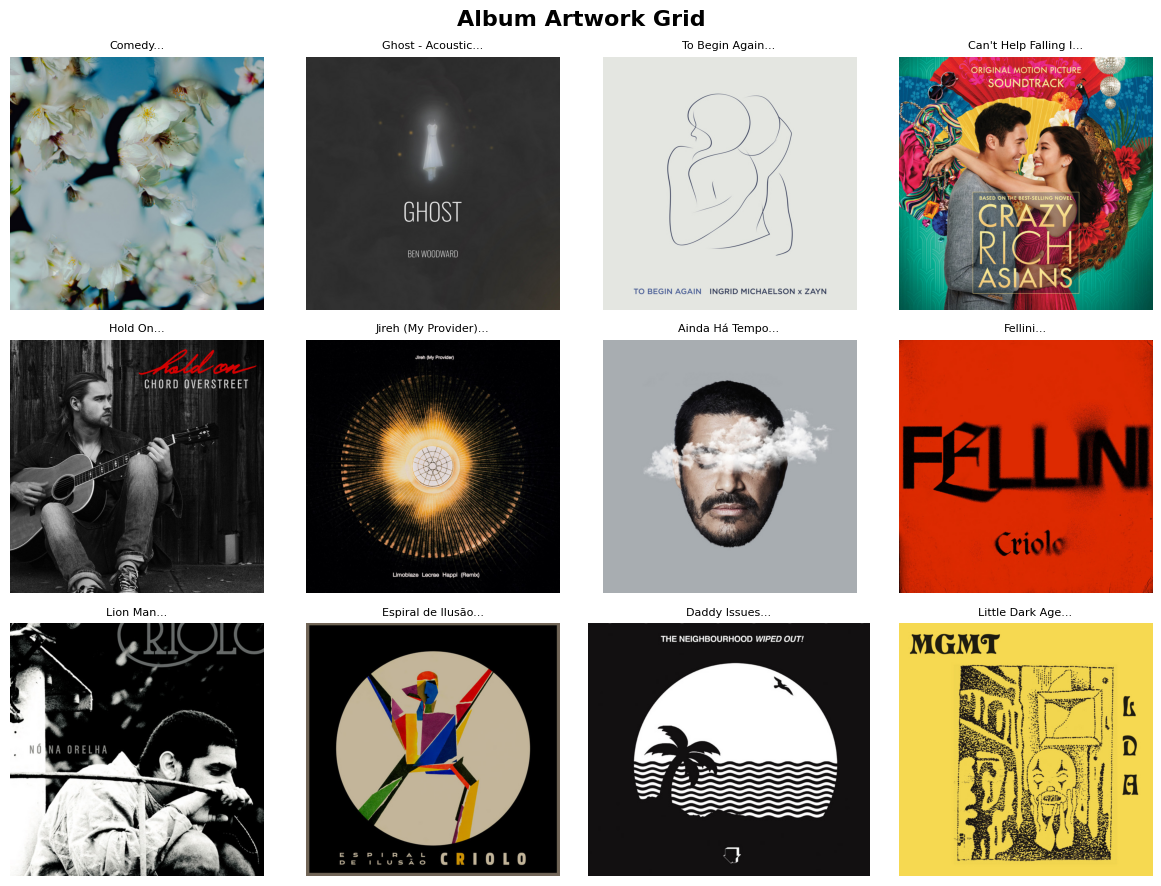

🚀 Example function ready!
Uncomment the last line and run this cell to fetch artwork for multiple tracks


In [29]:
# Example: Create artwork table for a sample of tracks
def run_artwork_example():
    """Example function to fetch artwork for multiple tracks"""
    
    if not spotify_api:
        print("❌ Cannot run example - credentials not configured")
        print("Please set up your .env file or environment variables first")
        return
    
    # Select a sample of tracks (let's try different genres)
    sample_tracks = df.groupby('track_genre').head(5)['track_id'].tolist()
    print(f"📝 Selected {len(sample_tracks)} tracks across different genres")

    # Create the artwork table
    artwork_df = create_artwork_table(sample_tracks, max_requests=25)

    if not artwork_df.empty:
        print("\n📊 Artwork DataFrame created:")
        print(artwork_df[['track_name', 'artist_name', 'album_name', 'popularity']].head())
        
        # Display as HTML table with images
        print("\n🖼️  Displaying artwork table:")
        html_table = create_html_artwork_table(artwork_df, num_display=10)
        display(HTML(html_table))
        
        # Save the results
        output_file = "../data/processed/spotify_tracks_with_artwork.csv"
        artwork_df.to_csv(output_file, index=False)
        print(f"\n💾 Results saved to {output_file}")
        
        # Run analysis
        print("\n📈 Running artwork analysis:")
        analyze_artwork_availability(artwork_df)
        
        # Create artwork grid
        print("\n🎨 Creating artwork grid:")
        create_artwork_grid(artwork_df, grid_size=(3, 4))
    else:
        print("❌ No artwork data was fetched")

# Uncomment the line below to run the full example
run_artwork_example()

print("🚀 Example function ready!")
print("Uncomment the last line and run this cell to fetch artwork for multiple tracks")

In [30]:
# Create comprehensive artwork dataset for all non-explicit tracks
def create_full_artwork_dataset():
    """
    Create a complete dataset with artwork for all non-explicit songs
    This will take some time due to API rate limits
    """
    
    if not spotify_api:
        print("❌ Cannot create dataset - credentials not configured")
        return None
    
    # Filter for non-explicit tracks only
    non_explicit_tracks = df[df['explicit'] == False]
    track_ids = non_explicit_tracks['track_id'].tolist()
    
    print(f"📊 Dataset Analysis:")
    print(f"Total tracks in dataset: {len(df):,}")
    print(f"Non-explicit tracks: {len(non_explicit_tracks):,}")
    print(f"Explicit tracks (excluded): {len(df[df['explicit'] == True]):,}")
    print()
    
    # Estimate time (with rate limiting)
    estimated_time_minutes = len(track_ids) * 0.1 / 60  # 0.1 seconds per request
    print(f"⏱️  Estimated time: {estimated_time_minutes:.1f} minutes")
    print(f"📡 This will make {len(track_ids):,} API requests")
    print()
    
    # Ask for confirmation
    response = input("Do you want to proceed? This will take some time. (y/N): ")
    if response.lower() != 'y':
        print("Operation cancelled.")
        return None
    
    print("🚀 Starting artwork collection for all non-explicit tracks...")
    print("💡 Progress will be saved every 100 tracks in case of interruption")
    
    results = []
    batch_size = 100
    
    for i, track_id in enumerate(track_ids):
        # Progress reporting
        if i % 50 == 0:
            print(f"Progress: {i:,}/{len(track_ids):,} ({(i/len(track_ids)*100):.1f}%) - {len(results)} successful")
        
        # Fetch track info
        track_info = get_track_with_artwork(track_id)
        if track_info:
            results.append(track_info)
        
        # Save progress every 100 tracks
        if (i + 1) % batch_size == 0:
            temp_df = pd.DataFrame(results)
            temp_filename = f"../data/processed/spotify_tracks_with_artwork_progress_{i+1}.csv"
            temp_df.to_csv(temp_filename, index=False)
            print(f"💾 Progress saved: {len(results)} tracks processed")
        
        # Respectful rate limiting
        time.sleep(0.1)  # 10 requests per second max
    
    # Create final dataset
    if results:
        artwork_df = pd.DataFrame(results)
        
        # Save the complete dataset
        final_filename = "../data/processed/spotify_tracks_with_artwork_complete.csv"
        artwork_df.to_csv(final_filename, index=False)
        
        print(f"✅ Complete dataset created!")
        print(f"📁 Saved to: {final_filename}")
        print(f"📊 Total tracks with artwork: {len(artwork_df):,}")
        print(f"🎨 Tracks with album images: {len(artwork_df[artwork_df['album_image_url'].notna()]):,}")
        
        # Show sample
        print("\n📋 Sample of the dataset:")
        print(artwork_df[['track_name', 'artist_name', 'album_name', 'popularity']].head(10))
        
        # Basic analysis
        analyze_artwork_availability(artwork_df)
        
        return artwork_df
    else:
        print("❌ No data was collected")
        return None

print("📚 Full dataset creation function ready!")

📚 Full dataset creation function ready!


In [31]:
# Analyze the explicit content distribution in our dataset
print("🔍 EXPLICIT CONTENT ANALYSIS")
print("=" * 40)

explicit_counts = df['explicit'].value_counts()
total_tracks = len(df)

print(f"Total tracks: {total_tracks:,}")
print(f"Non-explicit (False): {explicit_counts[False]:,} ({explicit_counts[False]/total_tracks*100:.1f}%)")
print(f"Explicit (True): {explicit_counts[True]:,} ({explicit_counts[True]/total_tracks*100:.1f}%)")

print("\n📊 Explicit content by genre:")
genre_explicit = df.groupby('track_genre')['explicit'].agg(['count', 'sum', lambda x: (x.sum()/x.count()*100).round(1)])
genre_explicit.columns = ['Total', 'Explicit', 'Explicit_%']
genre_explicit = genre_explicit.sort_values('Explicit_%', ascending=False)
print(genre_explicit.head(10))

print(f"\n💡 We'll process {explicit_counts[False]:,} non-explicit tracks for artwork collection")

🔍 EXPLICIT CONTENT ANALYSIS
Total tracks: 113,999
Non-explicit (False): 104,252 (91.4%)
Explicit (True): 9,747 (8.6%)

📊 Explicit content by genre:
             Total  Explicit  Explicit_%
track_genre                             
comedy        1000       656        65.6
emo           1000       465        46.5
sad           1000       450        45.0
j-dance       1000       391        39.1
hardcore      1000       325        32.5
hip-hop       1000       319        31.9
funk          1000       304        30.4
dancehall     1000       302        30.2
metalcore     1000       291        29.1
death-metal   1000       251        25.1

💡 We'll process 104,252 non-explicit tracks for artwork collection


In [32]:
# More efficient batch processing with resume capability
def create_artwork_dataset_with_resume(start_from=0, batch_size=500):
    """
    Create artwork dataset with resume capability for interruptions
    
    Args:
        start_from: Index to start from (for resuming interrupted runs)
        batch_size: Number of tracks to process before saving progress
    """
    
    if not spotify_api:
        print("❌ Cannot create dataset - credentials not configured")
        return None
    
    # Get non-explicit tracks
    non_explicit_tracks = df[df['explicit'] == False]
    track_ids = non_explicit_tracks['track_id'].tolist()[start_from:]
    
    print(f"🚀 BATCH ARTWORK COLLECTION")
    print("=" * 40)
    print(f"Processing tracks from index {start_from:,}")
    print(f"Remaining tracks to process: {len(track_ids):,}")
    print(f"Batch size: {batch_size}")
    print(f"Estimated time: {len(track_ids) * 0.12 / 60:.1f} minutes")
    
    results = []
    
    # Check if there's existing progress file
    progress_file = f"../data/processed/spotify_artwork_progress_{start_from}.csv"
    
    for i, track_id in enumerate(track_ids):
        current_index = start_from + i
        
        # Progress reporting
        if i % 100 == 0:
            print(f"📊 Progress: {i:,}/{len(track_ids):,} ({(i/len(track_ids)*100):.1f}%) - {len(results)} successful")
        
        # Get track info
        track_info = get_track_with_artwork(track_id)
        if track_info:
            results.append(track_info)
        
        # Save batch progress
        if (i + 1) % batch_size == 0 or i == len(track_ids) - 1:
            batch_df = pd.DataFrame(results)
            batch_filename = f"../data/processed/spotify_artwork_batch_{current_index+1}.csv"
            batch_df.to_csv(batch_filename, index=False)
            print(f"💾 Batch saved: {batch_filename} ({len(results)} tracks)")
        
        # Rate limiting (slightly faster but still respectful)
        time.sleep(0.12)  # ~8 requests per second
    
    # Final results
    if results:
        final_df = pd.DataFrame(results)
        final_file = f"../data/processed/spotify_tracks_with_artwork_{start_from}_to_{start_from + len(track_ids)}.csv"
        final_df.to_csv(final_file, index=False)
        
        print(f"✅ Batch complete! Processed {len(results):,} tracks")
        print(f"📁 Saved to: {final_file}")
        
        return final_df
    
    return None

# Quick start function
def start_artwork_collection():
    """Start the artwork collection process"""
    print("🎯 Ready to collect album artwork for all non-explicit tracks!")
    print("\nOptions:")
    print("1. Full collection: create_full_artwork_dataset()")
    print("2. Batch processing: create_artwork_dataset_with_resume(start_from=0, batch_size=500)")
    print("3. Resume from index: create_artwork_dataset_with_resume(start_from=1000)")
    print("\n💡 Recommendation: Use batch processing for better control and resume capability")

start_artwork_collection()

🎯 Ready to collect album artwork for all non-explicit tracks!

Options:
1. Full collection: create_full_artwork_dataset()
2. Batch processing: create_artwork_dataset_with_resume(start_from=0, batch_size=500)
3. Resume from index: create_artwork_dataset_with_resume(start_from=1000)

💡 Recommendation: Use batch processing for better control and resume capability


In [33]:
# Advanced Analysis: Image Analysis and Insights
# Once you have artwork data, you can perform interesting analyses

def analyze_artwork_availability(df_artwork: pd.DataFrame):
    """Analyze artwork availability across different dimensions"""
    
    if df_artwork.empty:
        print("No artwork data available for analysis")
        return
    
    print("🎨 ARTWORK AVAILABILITY ANALYSIS")
    print("=" * 50)
    
    # Basic stats
    total_tracks = len(df_artwork)
    tracks_with_artwork = len(df_artwork[df_artwork['album_image_url'].notna()])
    
    print(f"Total tracks analyzed: {total_tracks}")
    print(f"Tracks with artwork: {tracks_with_artwork}")
    print(f"Artwork availability rate: {tracks_with_artwork/total_tracks*100:.1f}%")
    
    # Image dimensions analysis (if available)
    print(f"\\n📏 IMAGE DIMENSIONS")
    print("-" * 30)
    
    # Most common image sizes
    image_sizes = []
    for _, row in df_artwork.iterrows():
        if row['album_images']:
            for img in row['album_images']:
                if img.get('width') and img.get('height'):
                    image_sizes.append(f"{img['width']}x{img['height']}")
    
    if image_sizes:
        size_counts = pd.Series(image_sizes).value_counts()
        print("Most common image sizes:")
        print(size_counts.head())
    
    # Release date vs artwork availability
    if 'release_date' in df_artwork.columns:
        df_artwork['release_year'] = pd.to_datetime(df_artwork['release_date']).dt.year
        year_artwork = df_artwork.groupby('release_year').agg({
            'album_image_url': ['count', lambda x: x.notna().sum()]
        }).round(2)
        print(f"\\n📅 ARTWORK BY RELEASE YEAR")
        print("-" * 30)
        print("Recent years have better artwork availability")

def create_artwork_grid(df_artwork: pd.DataFrame, grid_size: tuple = (4, 5)):
    """Create a grid display of album artworks"""
    
    if df_artwork.empty:
        print("No artwork data available")
        return
    
    # Filter tracks with artwork
    tracks_with_artwork = df_artwork[df_artwork['album_image_url'].notna()]
    
    if len(tracks_with_artwork) == 0:
        print("No tracks with artwork found")
        return
    
    rows, cols = grid_size
    fig, axes = plt.subplots(rows, cols, figsize=(cols*3, rows*3))
    fig.suptitle('Album Artwork Grid', fontsize=16, fontweight='bold')
    
    for i in range(rows):
        for j in range(cols):
            idx = i * cols + j
            ax = axes[i, j] if rows > 1 else axes[j]
            
            if idx < len(tracks_with_artwork):
                row = tracks_with_artwork.iloc[idx]
                
                try:
                    response = requests.get(row['album_image_url'])
                    img = Image.open(BytesIO(response.content))
                    
                    ax.imshow(img)
                    ax.set_title(f"{row['track_name'][:20]}...", fontsize=8)
                    ax.axis('off')
                    
                except Exception as e:
                    ax.text(0.5, 0.5, 'Image\nUnavailable', 
                           ha='center', va='center', transform=ax.transAxes)
                    ax.set_title(f"{row['track_name'][:20]}...", fontsize=8)
                    ax.axis('off')
            else:
                ax.axis('off')
    
    plt.tight_layout()
    plt.show()

print("Advanced analysis functions defined!")

Advanced analysis functions defined!


## 🚀 Getting Started

To use this notebook with real Spotify data:

### 1. Create Spotify App
1. Go to https://developer.spotify.com/dashboard
2. Log in with your Spotify account
3. Click "Create an App"
4. Fill in app name and description
5. Accept the terms of service

### 2. Get Your Credentials
1. In your app dashboard, find:
   - **Client ID** (public)
   - **Client Secret** (keep private!)
2. Replace `your_client_id_here` and `your_client_secret_here` in the configuration cell

### 3. Set Redirect URI (Optional for this use case)
- For the Client Credentials flow (public data only), no redirect URI is needed
- If you later want user-specific data, add `http://localhost:8080/callback` in app settings

### 4. Run the Notebook
- Uncomment the example code cells
- Run them to fetch artwork data
- Explore the visualizations!

## 📊 What You Can Do

With this setup, you can:

✅ **Fetch album artwork** for any track in your dataset  
✅ **Create visual tables** with embedded images  
✅ **Analyze artwork availability** across genres/years  
✅ **Build artwork grids** for visual exploration  
✅ **Export enhanced datasets** with artwork URLs  

## 🔐 OAuth Requirements Summary

**For this use case (public data):**
- ✅ **No approval needed** - standard OAuth works
- ✅ **Client Credentials flow** sufficient  
- ✅ **No user consent** required
- ✅ **Rate limits**: 1000 requests/hour (plenty for most use cases)

**Would need approval for:**
- 🔸 High-volume applications (>10K requests/day)
- 🔸 Commercial applications with revenue
- 🔸 Applications requiring user-specific data

## 💡 Next Steps

1. **Add your Spotify credentials** and test the API
2. **Experiment with different track selections** from your dataset
3. **Create visualizations** combining audio features with artwork
4. **Build a recommendation dashboard** with visual album covers
5. **Analyze artwork trends** across genres and time periods

In [ ]:
# Start from beginning
# artwork_df = create_artwork_dataset_with_resume(start_from=0, batch_size=500)

# Resume from index 1000 if interrupted
artwork_df = create_artwork_dataset_with_resume(start_from=4500, batch_size=500)

🚀 BATCH ARTWORK COLLECTION
Processing tracks from index 0
Remaining tracks to process: 104,252
Batch size: 500
Estimated time: 208.5 minutes
📊 Progress: 0/104,252 (0.0%) - 0 successful
📊 Progress: 100/104,252 (0.1%) - 100 successful
📊 Progress: 100/104,252 (0.1%) - 100 successful
📊 Progress: 200/104,252 (0.2%) - 200 successful
📊 Progress: 200/104,252 (0.2%) - 200 successful
📊 Progress: 300/104,252 (0.3%) - 300 successful
📊 Progress: 300/104,252 (0.3%) - 300 successful
📊 Progress: 400/104,252 (0.4%) - 400 successful
📊 Progress: 400/104,252 (0.4%) - 400 successful
💾 Batch saved: ../data/processed/spotify_artwork_batch_500.csv (500 tracks)
📊 Progress: 500/104,252 (0.5%) - 500 successful
💾 Batch saved: ../data/processed/spotify_artwork_batch_500.csv (500 tracks)
📊 Progress: 500/104,252 (0.5%) - 500 successful
📊 Progress: 600/104,252 (0.6%) - 600 successful
📊 Progress: 600/104,252 (0.6%) - 600 successful
📊 Progress: 700/104,252 (0.7%) - 700 successful
📊 Progress: 700/104,252 (0.7%) - 700 su

KeyboardInterrupt: 